In [1]:
import numpy as np
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process


def integrated_oscillator(dt, num_steps, x0=0, y0=1, angular_frequency=2*np.pi*1e-3):
    """
    Parameters
    ----------
    dt : float
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0 : float
        Initial values in three dimensional space.
    angular_frequency : float
        Angular frequency in 1/ms.

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (2, num_steps) np.ndarray
        Integrated two-dimensional trajectory (x, y, z) of the harmonic oscillator
    """

    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    x = x0*np.cos(angular_frequency*t) + y0*np.sin(angular_frequency*t)
    y = -x0*np.sin(angular_frequency*t) + y0*np.cos(angular_frequency*t)
    return t, np.array((x, y))


def integrated_lorenz(dt, num_steps, x0=0, y0=1, z0=1.05,
                      sigma=10, rho=28, beta=2.667, tau=1e3):
    """

    Parameters
    ----------
    dt :
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0, z0 : float
        Initial values in three dimensional space
    sigma, rho, beta : float
        Parameters defining the lorenz attractor
    tau : characteristic timescale in ms

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (3, num_steps) np.ndarray
        Integrated three-dimensional trajectory (x, y, z) of the Lorenz attractor
    """
    def _lorenz_ode(point_of_interest, timepoint, sigma, rho, beta, tau):
        """
        Fit the model with `spiketrains` data and apply the dimensionality
        reduction on `spiketrains`.

        Parameters
        ----------
        point_of_interest : tuple
            Tupel containing coordinates (x,y,z) in three dimensional space.
        timepoint : a point of interest in time
        dt :
            Integration time step in ms.
        num_steps : int
            Number of integration steps -> max_time = dt*(num_steps-1).
        sigma, rho, beta : float
            Parameters defining the lorenz attractor
        tau : characteristic timescale in ms

        Returns
        -------
        x_dot, y_dot, z_dot : float
            Values of the lorenz attractor's partial derivatives
            at the point x, y, z.
        """

        x, y, z = point_of_interest

        x_dot = (sigma*(y - x)) / tau
        y_dot = (rho*x - y - x*z) / tau
        z_dot = (x*y - beta*z) / tau
        return x_dot, y_dot, z_dot

    assert isinstance(num_steps, int), "num_steps has to be integer"

    t = dt*np.arange(num_steps)
    poi = (x0, y0, z0)
    return t, odeint(_lorenz_ode, poi, t, args=(sigma, rho, beta, tau)).T


def random_projection(data, embedding_dimension, loc=0, scale=None):
    """
    Parameters
    ----------
    data : np.ndarray
        Data to embed, shape=(M, N)
    embedding_dimension : int
        Embedding dimension, dimensionality of the space to project to.
    loc : float or array_like of floats
        Mean (“centre”) of the distribution.
    scale : float or array_like of floats
        Standard deviation (spread or “width”) of the distribution.

    Returns
    -------
    np.ndarray
       Random (normal) projection of input data, shape=(dim, N)

    See Also
    --------
    np.random.normal()

    """
    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data.shape[0]))
    return np.dot(projection_matrix, data)


def generate_spiketrains(instantaneous_rates, num_trials, timestep):
    """
    Parameters
    ----------
    instantaneous_rates : np.ndarray
        Array containing time series.
    timestep :
        Sample period.
    num_steps : int
        Number of timesteps -> max_time = timestep*(num_steps-1).

    Returns
    -------
    spiketrains : list of neo.SpikeTrains
        List containing spiketrains of inhomogeneous Poisson
        processes based on given instantaneous rates.

    """

    spiketrains = []
    for _ in range(num_trials):
        spiketrains_per_trial = []
        for inst_rate in instantaneous_rates:
            anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
            spiketrains_per_trial.append(inhomogeneous_poisson_process(anasig_inst_rate))
        spiketrains.append(spiketrains_per_trial)

    return spiketrains

In [36]:
# set parameters for the integration of the harmonic oscillator
timestep = 1 * pq.ms
trial_duration = 0.5 * pq.s
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data size
num_trials = 100
num_spiketrains = 50

# generate a low-dimensional trajectory
times_oscillator, oscillator_trajectory_2dim = integrated_oscillator(
    timestep.magnitude, num_steps=num_steps, x0=0, y0=1)
times_oscillator = (times_oscillator*timestep.units).rescale('s')

# random projection to high-dimensional space
oscillator_trajectory_Ndim = random_projection(
    oscillator_trajectory_2dim, embedding_dimension=num_spiketrains)

# convert to instantaneous rate for Poisson process
normed_traj = oscillator_trajectory_Ndim / oscillator_trajectory_Ndim.max()
instantaneous_rates_oscillator = np.power(max_rate.magnitude, normed_traj)

# generate spike trains
spiketrains_oscillator = generate_spiketrains(
    instantaneous_rates_oscillator, num_trials, timestep)

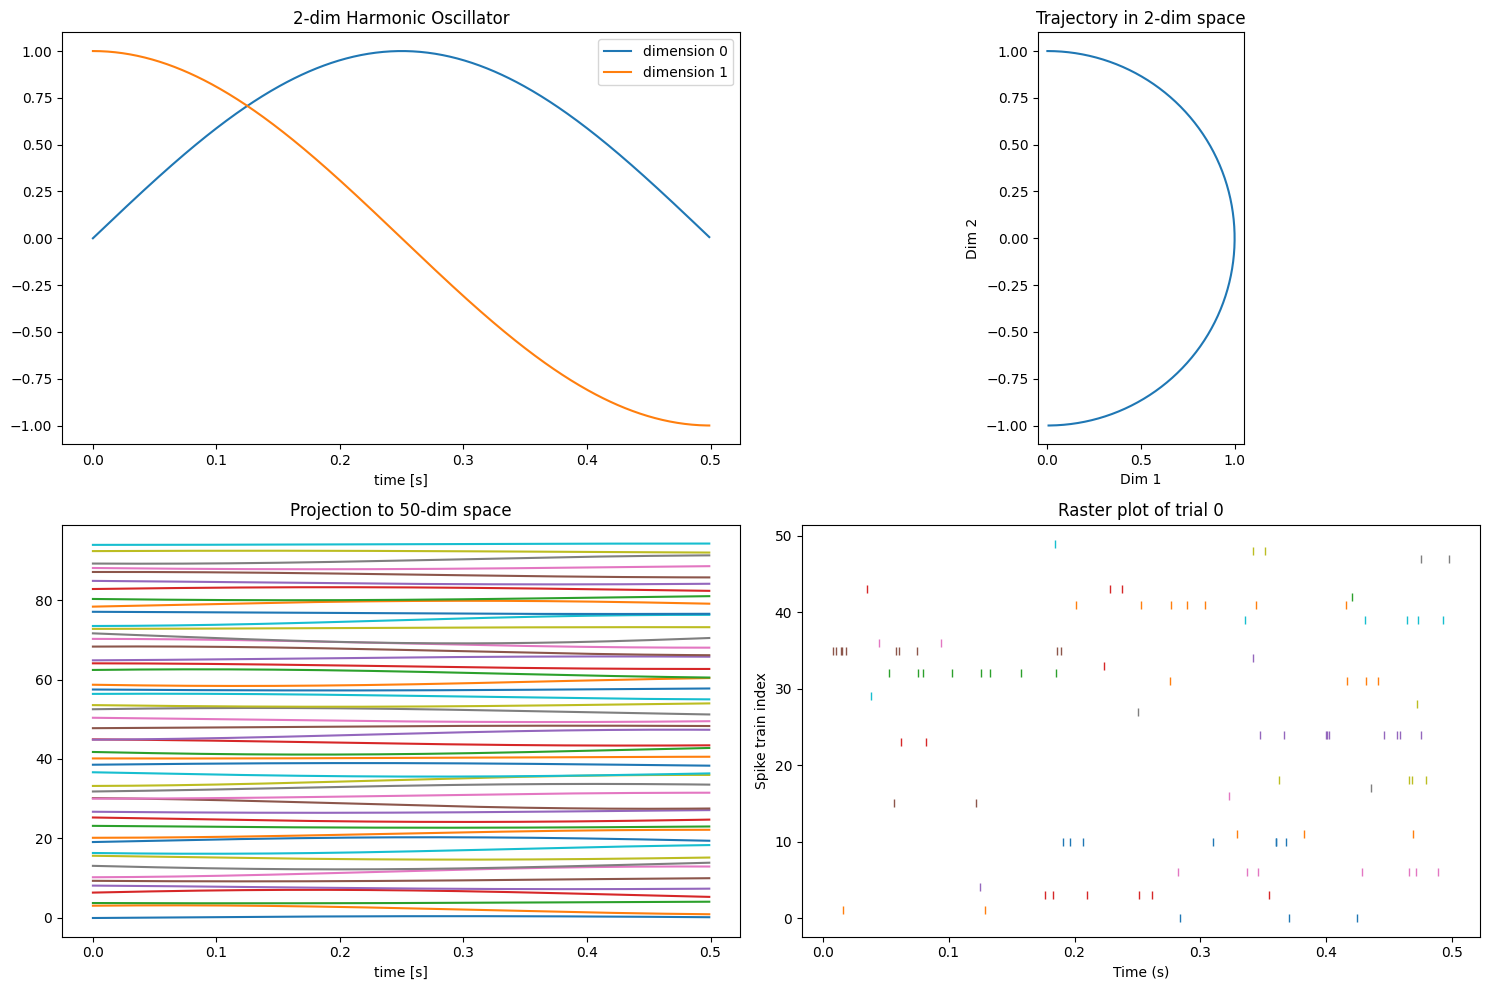

In [37]:
import matplotlib.pyplot as plt


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.set_title('2-dim Harmonic Oscillator')
ax1.set_xlabel('time [s]')
for i, y in enumerate(oscillator_trajectory_2dim):
    ax1.plot(times_oscillator, y, label=f'dimension {i}')
ax1.legend()

ax2.set_title('Trajectory in 2-dim space')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
ax2.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('time [s]')
y_offset = oscillator_trajectory_Ndim.std() * 3
for i, y in enumerate(oscillator_trajectory_Ndim):
    ax3.plot(times_oscillator, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Spike train index')
for i, spiketrain in enumerate(spiketrains_oscillator[trial_to_plot]):
    ax4.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

In [38]:
from elephant.gpfa import GPFA


# specify fitting parameters
bin_size = 10 * pq.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [39]:
gpfa_2dim.fit(spiketrains_oscillator[:num_trials//2])
trajectories = gpfa_2dim.transform(spiketrains_oscillator[num_trials//2:])

Initializing parameters using factor analysis...

Fitting GPFA model...


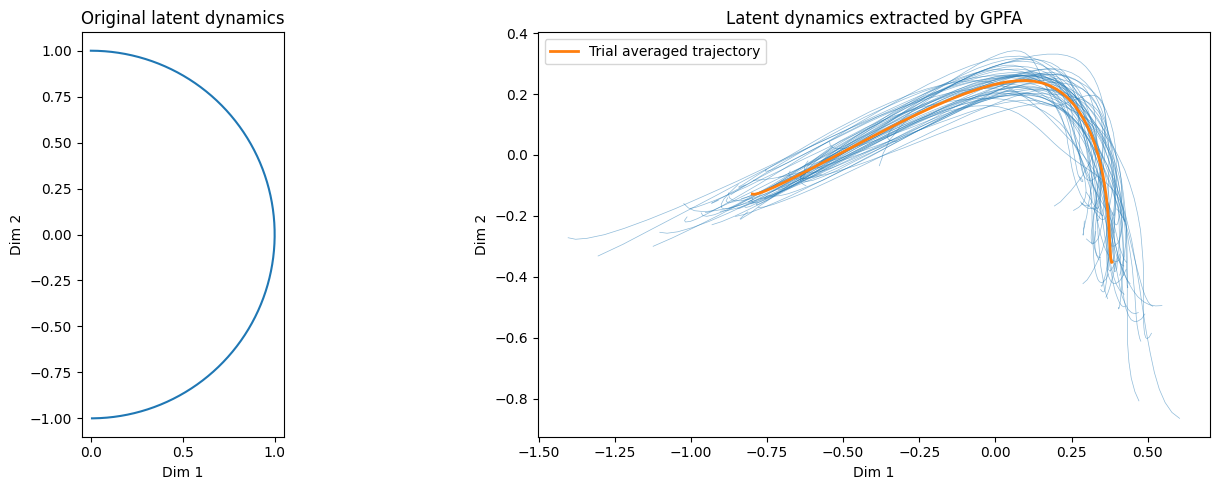

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
ax1.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()

plt.tight_layout()
plt.show()

In [41]:
n_neuron = len(spiketrains_oscillator[0])
time_length = 500 
bin_size = 1.0  

binarized_trials = []
for trial in spiketrains_oscillator:
    trial_matrix = np.zeros((n_neuron, time_length), dtype=np.int8)
    for i, spk in enumerate(trial):
        spike_times_ms = np.rint(spk.rescale('ms').magnitude).astype(int)
        spike_times_ms = spike_times_ms[(spike_times_ms >= 0) & (spike_times_ms < time_length)]
        trial_matrix[i, spike_times_ms] = 1
    binarized_trials.append(trial_matrix)

In [42]:
import torch
import torch.nn as nn
from spikingjelly.activation_based import neuron, layer, functional, surrogate

class SpikeEncoder(nn.Module):
    def __init__(self, input_size=40, hidden_sizes=[30, 20, 10], latent_size=3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.lif1 = neuron.LIFNode(v_threshold=0.5, surrogate_function=surrogate.ATan(), detach_reset=True)
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.lif2 = neuron.LIFNode(v_threshold=0.5, surrogate_function=surrogate.ATan(), detach_reset=True)
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.lif3 = neuron.LIFNode(v_threshold=0.5, surrogate_function=surrogate.ATan(), detach_reset=True)
        self.fc4 = nn.Linear(hidden_sizes[2], latent_size)
        self.lif4 = neuron.LIFNode(v_threshold=0.5, surrogate_function=surrogate.ATan(), detach_reset=True)

    def forward(self, x):
        # x: (batch, n_neuron, time)
        batch, n_neuron, time = x.shape
        out = []
        self.reset()
        for t in range(time):
            xt = x[:, :, t]
            h = self.lif1(self.fc1(xt))
            h = self.lif2(self.fc2(h))
            h = self.lif3(self.fc3(h))
            h = self.lif4(self.fc4(h))
            out.append(h.unsqueeze(-1))
        return torch.cat(out, dim=-1)  # (batch, latent_size, time)

    def reset(self):
        self.lif1.reset()
        self.lif2.reset()
        self.lif3.reset()
        self.lif4.reset()

class SpikeDecoder(nn.Module):
    def __init__(self, latent_size=3, hidden_sizes=[10, 20, 30], output_size=40):
        super().__init__()
        self.fc1 = nn.Linear(latent_size, hidden_sizes[0])
        self.lif1 = neuron.LIFNode(v_threshold=0.5, surrogate_function=surrogate.ATan(), detach_reset=True)
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.lif2 = neuron.LIFNode(v_threshold=0.5, surrogate_function=surrogate.ATan(), detach_reset=True)
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.lif3 = neuron.LIFNode(v_threshold=0.5, surrogate_function=surrogate.ATan(), detach_reset=True)
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        # 训练期不做最后一层脉冲化，便于用 BCEWithLogitsLoss 优化

    def forward(self, x):
        # x: (batch, latent_size, time)
        batch, latent_size, time = x.shape
        out = []
        self.reset()
        for t in range(time):
            xt = x[:, :, t]
            h = self.lif1(self.fc1(xt))
            h = self.lif2(self.fc2(h))
            h = self.lif3(self.fc3(h))
            h = self.fc4(h)  # logits，不经过 LIF
            out.append(h.unsqueeze(-1))
        return torch.cat(out, dim=-1)  # (batch, output_size, time)

    def reset(self):
        self.lif1.reset()
        self.lif2.reset()
        self.lif3.reset()

class SpikeAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = SpikeEncoder()
        self.decoder = SpikeDecoder()

    def forward(self, x):
        self.encoder.reset()
        self.decoder.reset()
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

In [46]:
# 将 binarized_trials 切分为训练/测试并创建 DataLoader
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class TrialsDataset(Dataset):
    def __init__(self, trials_list):
        # trials_list: list of np.ndarray, each (n_neuron, time)
        self.tensors = [torch.from_numpy(arr).float() for arr in trials_list]

    def __len__(self):
        return len(self.tensors)

    def __getitem__(self, idx):
        x = self.tensors[idx]  # (n_neuron, time)
        return x

# 构建全集Dataset
full_dataset = TrialsDataset(binarized_trials)

# 划分比例
train_ratio = 0.8
n_total = len(full_dataset)
train_len = int(n_total * train_ratio)
test_len = n_total - train_len
train_set, test_set = random_split(full_dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

# DataLoader
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

n_neuron = full_dataset[0].shape[0]
time_steps = full_dataset[0].shape[1]
print(f"Dataset: {n_total} samples, train {train_len}, test {test_len}, shape=({n_neuron},{time_steps})")


Dataset: 100 samples, train 80, test 20, shape=(50,500)


In [47]:
# 训练：SNN 自编码器（使用可微替代梯度+BCEWithLogitsLoss+发放率正则）
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from spikingjelly.activation_based import functional as sjF

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpikeAutoencoder().to(device)

# 根据数据动态设置输入/输出尺寸
model.encoder.fc1 = nn.Linear(n_neuron, 30).to(device)
model.decoder.fc4 = nn.Linear(30, n_neuron).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

# 目标发放率与权重（可调，帮助避免全 0）
rate_target = 0.05
rate_lambda = 1e-3

num_epochs = 10
log_interval = 1
max_grad_norm = 1.0

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        # batch: (batch, n_neuron, time), 值域为 {0,1}
        batch = batch.to(device)
        optimizer.zero_grad()

        # 重置网络状态（双保险，模型 forward 内也会 reset）
        sjF.reset_net(model)

        out, z = model(batch)  # out: logits, z: latent spikes
        recon_loss = criterion(out, batch)
        # 轻量发放率正则：鼓励 z 的平均发放率接近 rate_target
        z_rate = z.mean()
        rate_reg = (z_rate - rate_target).abs()
        loss = recon_loss + rate_lambda * rate_reg

        loss.backward()
        clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        epoch_loss += loss.item() * batch.size(0)

    epoch_loss /= len(train_loader.dataset)

    if epoch % log_interval == 0:
        print(f"Epoch {epoch}/{num_epochs} - train loss: {epoch_loss:.6f} (z_rate={z_rate.item():.4f})")


AttributeError: module 'torch._subclasses.fake_tensor' has no attribute 'UnsupportedMutationAliasingException'

In [ ]:
# 测试与导出 latent 层脉冲序列
import os

model.eval()
all_latent_spikes = []  # list of (batch, latent_size, time)
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        recon, latent = model(batch)
        # latent 为经过 LIF 的脉冲输出
        all_latent_spikes.append(latent.cpu())

all_latent_spikes = torch.cat(all_latent_spikes, dim=0)  # (N_test, latent_size, time)
print('latent shape:', all_latent_spikes.shape)



latent shape: torch.Size([20, 3, 2000])


In [14]:
import numpy as np
import quantities as pq
import neo
from elephant.statistics import instantaneous_rate
from elephant.kernels import GaussianKernel


latent_np = (all_latent_spikes.cpu().numpy() > 0).astype(np.uint8)  # (N_test, latent_size, time)
N_test, latent_size, T = latent_np.shape

# 将每个 trial 的每个 latent 单元转换为 neo.SpikeTrain（单位：ms）
latent_spiketrains = []  # list[list[neo.SpikeTrain]]
for n in range(N_test):
    trial_sts = []
    for u in range(latent_size):
        spike_idx = np.nonzero(latent_np[n, u])[0]
        spike_times = (spike_idx * pq.ms)  # bin 宽度 1 ms
        st = neo.SpikeTrain(spike_times, t_start=0*pq.ms, t_stop=T*pq.ms)
        trial_sts.append(st)
    latent_spiketrains.append(trial_sts)

# 用 GaussianKernel 计算瞬时发放率（采样周期 10 ms）
sampling_period = 20 * pq.ms
kernel_sigma = 60 * pq.ms  # 可调
gk = GaussianKernel(sigma=kernel_sigma)

# 计算并对齐到相同长度（象限：每条轨迹返回 AnalogSignal）
latent_inst_rates = []  # list[np.ndarray (latent_size, T_rate)]
for trial_sts in latent_spiketrains:
    trial_rates = []
    for st in trial_sts:
        r = instantaneous_rate(st, kernel=gk, sampling_period=sampling_period)
        trial_rates.append(r.magnitude.squeeze())  # (T_rate,)
    trial_rates = np.stack(trial_rates, axis=0)  # (latent_size, T_rate)
    latent_inst_rates.append(trial_rates)

latent_inst_rates = np.stack(latent_inst_rates, axis=0)  # (N_test, latent_size, T_rate)
print('latent_inst_rates shape:', latent_inst_rates.shape)




latent_inst_rates shape: (20, 3, 100)
